# Single Shot Multi Scale Object Detection Tutorial


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
import os

import PIL
import matplotlib

import torch
from easyimages.utils import change_box_order, vis_image
from livelossplot import PlotLosses
from pycocotools.coco import COCO
from retinanet.encoder import DataEncoder
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler
from torchvision.transforms import ToPILImage, ToTensor
import torch.nn.functional as F
from torch.autograd import Variable
from retinanet.utils import one_hot_embedding
from retinanet.loss import FocalLoss


matplotlib.rcParams['figure.figsize'] = [14, 10]


device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Object Detection

Object detection is the process of localizing and classyfing a region of interest in an image. Usually by prediting the coordinates of a bounding box enclosing this object.

In this notebook we focus on single shot methods detection which means that the detection happens during a single forward pass. There is no second network learning object proposals which would be the case in RCNN architectures.



# Example (Synthetic) Object Detection Dataset

Our problem boils down to predicting the coordinates and label of the red box given an input image.

![alt text](static/shapes-coco.png "Title")


# COCO Dataset Annotations Format

COCO format  is the standard for storing object detection and segmentation data so we will work on an example  following the same.

In COCO we follow the **xywh** convention or as i like to call it *tlwh*: **(top-left-width-height)**
that way you can not confuse it with for instance *cwh*: **(center-point, w, h)**

![alt text](static/cocodsformat.jpg "Title")


# Bounding Box Encoding

Probably the most challenging concept to grasp while learning  object detection is the way how we encode our ground truth information. This is a crucial step in most applications in  deep learning, usually its not that complicated for instance encoding categories as one-hot encoded vectors is a straight forward task, but it can get quite challenging for example in NLP problems where its common to have variable sequence lenghts.

In a regular bounding box setup your image can have different number of boxes and classes per image. So how do you encode this information into a fixed size target-tensor?

The solution to this problem are **Anchor Boxes** also known as prior boxes.

Essentialy Anchor Boxes are a finite set of boundig boxes with different sizes and aspect ratios for each position in the feature map. Usually there are thousands of anchor boxes in modern OD architectures - but only few will "match" with our ground truth.


![alt text](static/anchors3.png "All")

Here we visualize 100 random anchor boxes. Next up we will find which ones match our ground-truth using a crieteria known as IoU (Intersection over union)

![alt text](static/iou.png "All")


![alt text](static/matched_anchors.png "All")


# Bounding Box Regression Coefficients

Since predicting the anchor itself would be suboptimal (having IoU's close to 1.0 is unlikely even with a very high number of anchors) Thats why we want our network to predict an offset between the real box (T) and the Anchor (O) and for the width and height we learn the ratio between the Target width and Anchor width. Furthermore its quite common to log-transform this target for more efficient training.

We will only use coefficients coming from Anchor boxes with high IoU (usually above 0.5) the rest is ignored in regression loss computation.

![alt text](static/anchor_coef.png "All")

Now the question arises how do you predict those offsets, the trick to this is attaching the detection heads to regular feature maps of a convolutiona neural network (base network)

To understand what it means here is a qucik recap of a typical CNN architecture w.r.t Object Detection an important concept is the receptive field of a neuron and the fact that the deeper you go in regular CNN you trade resolution for "broad-knowledge" neurons deep in a neural network are more context aware.

![alt text](static/cnn.jpg "All")

Given that it would make sense to use higher resolution feature maps (for instance the 56x56 f-map) to predict small objects and lower resolution ones for big objects. And thats exactly the idea behind **multi scale object detection**



# Regression and Detection Heads

A regression and detection head is nothing else then a Conv2D block that is convolving a particular feature map. In the most simplified scennario it would work like this:

```python
num_classes = 3
fmap1 = torch.random(BS, 256, 9, 9) # Lets assume this is a 9x9 feature map with depth=256.
bbox_regression_head = nn.Conv2d(32, n_anchors * 4, 3, padding=1)
bbox_classification_head = nn.Conv2d(32, n_anchors * num_classes, 3, padding=1)

bbox_offsets = bbox_regression_head(fmap1)
bbox_cls_pred = bbox_classification_head(fmap1)

```
n_anchors is the number of anchor per location (its pretty common this number is 9 as we have 3 scale ratios and 3 aspect ratios) so the product of those is 9.
For regression we multiple this by **4** (we need 4 floats for each anchor to predict the offsets tx,ty,tw,th)

Notice how elegant this solution actually is - we have a fully convolutional architecture (which is usually quite efficient memory and speed-wise) it also makes sense intuitivly - convolution is nothing else but sliding a filter on each position of the feature maps, and we know that those neurons have 'knowledge' about a particular part of the image (among other things)




# Encoding steps put together

To recap the above:  here are the steps neccesery to encode our target bounding boxes:

- For each feature map that we want to use for predictions generate a set of anchor-boxes with different size and aspect ratios
- Calculate the IoU between your target boxes and anchor boxes
- For anchors that had the biggest IoU  calculate the offset values.
    tx = (x - anchor_x) / anchor_w
    ty = (y - anchor_y) / anchor_h
    tw = log(w / anchor_w)
    th = log(h / anchor_h)

- For box regression only offsets  that matched with an IoU > 0.5 will be used during loss computation
- For box classification only boxes with IoU > 0.5 and  IoU < 0.4 will be used during loss computetion

# Data Encoding Examples

In [2]:

de = DataEncoder(anchor_areas=[50*50, 100*100, 200*200],
                 aspect_ratios=[0.5, 1, 2],
                 scale_ratios=[1.0, 1.25, 1.5],
                 fm_sizes=torch.tensor([(37, 37),
                                        (18, 18),
                                        (9, 9)]).float(),

                 min_iou=0.5
                 )

anchors, anchors_per_fm = de._get_anchor_boxes(torch.Tensor((300, 300)))

# for fms in anchors_per_fm:
#     print(fms.shape)
    
# fms

anchors_per_fm[2]

tensor([[ 16.6667,  16.6667, 141.4214, 282.8427],
        [ 16.6667,  16.6667, 176.7767, 353.5534],
        [ 16.6667,  16.6667, 212.1320, 424.2641],
        ...,
        [283.3333, 283.3333, 282.8427, 141.4214],
        [283.3333, 283.3333, 353.5534, 176.7767],
        [283.3333, 283.3333, 424.2641, 212.1320]])

Lets make sure we understand where the number are coming from:

- We have 12321 anchors on fm1 (37 * 37 *9)
- We have 2916 anchors on fm2 (18 * 18 * 9)
- We have 729 anchors on fm3 (9 * 9 * 9)



# Wrapping COCO dataset into a pytorch dataset


In [3]:
coco = COCO(annotation_file='generate-shapes/coco_shapes_100_200/100_200.json')


class CoCoDS():
    def __init__(self, coco, base_path, encoder):
        self.coco = coco
        self.base_path = base_path
        self.encoder = encoder
        self.all_images = coco.getImgIds()

    def __getitem__(self, i):

        image_id = self.all_images[i]
        image_meta = coco.loadImgs(ids=[image_id])[0]
        image = PIL.Image.open(os.path.join(self.base_path, image_id))
        image = ToTensor()(image)

        w, h = image_meta['width'], image_meta['height']
        annot = coco.loadAnns(ids=coco.getAnnIds(imgIds=[image_id]))
        boxes = torch.tensor([a['bbox'] for a in annot]).float()
        labels = torch.tensor([a['category_id']for a in annot]).float()
        boxes = change_box_order(
            boxes, input_order='tlwh', output_order='tlbr')

        loc_targets, cls_targets = self.encoder.encode(boxes, labels, (w, h))

        return image, loc_targets, cls_targets

    def __len__(self):
        return len(self.coco.getImgIds())

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [4]:
cocds = CoCoDS(coco, 'generate-shapes/coco_shapes_100_200/images', de)

_, loc, cls = cocds[0]

print(loc.shape)
print(cls.shape)

torch.Size([15966, 4])
torch.Size([15966])


# Lets model a very simple network
Our network is really simple it consists of 5 downsample steps. Each downsample is a **Conv2->BN->Relu->Conv2->BN->Relu->MaxPool2D** block. 

We will attach our detection heads to f-map3 f-map4 and f-map5. Lets caculate the shapes of those feature maps:

outpu shape  after step 3 -> 300 / 2 / 2 / 2 = 37   
output shape after step 4 -> 300 / 2 / 2 / 2 / 2  = 18   
output shape after step 5 -> 300 / 2 / 2 / 2 / 2 / 2 = 9   

As you can imagine the Anchor boxes reflect this architecture. In the end all the shape must match.

In [5]:

class SimpleSSD(nn.Module):

    def __init__(self, n_cls=1, num_anchors=9):
        super(SimpleSSD, self).__init__()

        self.n_cls = n_cls
        self.num_anchors = num_anchors

        # Base CNN (think resnet/vgg or other base network)
        self.step1 = self.down_sample(3, 128)
        self.step2 = self.down_sample(128, 128)
        self.step3 = self.down_sample(128, 128)
        self.step4 = self.down_sample(128, 128)
        self.step5 = self.down_sample(128, 128)

        self.cls_head1 = self.create_cls_head(
            128, self.n_cls, self.num_anchors)
        self.bbox_head1 = self.create_bbox_head(128, self.num_anchors)

        self.cls_head2 = self.create_cls_head(
            128, self.n_cls, self.num_anchors)
        self.bbox_head2 = self.create_bbox_head(128, self.num_anchors)

        self.cls_head3 = self.create_cls_head(
            128, self.n_cls, self.num_anchors)
        self.bbox_head3 = self.create_bbox_head(128, self.num_anchors)

    @staticmethod
    def down_sample(in_channels, out_channels):

        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

    @staticmethod
    def create_cls_head(n_in, n_cls, num_anchors):
        return nn.Sequential(
            nn.Conv2d(n_in, 92, 3, padding=1),
            nn.BatchNorm2d(92),
            nn.ReLU(),
            nn.Conv2d(92, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, num_anchors * n_cls, 3, stride=1, padding=1),
        )

    @staticmethod
    def create_bbox_head(n_in, num_anchors):
        return nn.Sequential(
            nn.Conv2d(n_in, 92, 3, padding=1),
            nn.BatchNorm2d(92),
            nn.ReLU(),
            nn.Conv2d(92, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,  num_anchors * 4, 3, stride=1, padding=1))

    def forward(self, x):

        # x -> [BS, 3, 300, 300]

        step1 = self.step1(x)
        step2 = self.step2(step1)
        step3 = self.step3(step2)
        step4 = self.step4(step3)
        step5 = self.step5(step4)

        cls1 = self.cls_head1(step3)
        bbox1 = self.bbox_head1(step3)

        cls2 = self.cls_head2(step4)
        bbox2 = self.bbox_head2(step4)

        cls3 = self.cls_head3(step5)
        bbox3 = self.bbox_head3(step5)
        
        

        cls1 = cls1.permute(0, 2, 3, 1).contiguous().view(
            x.size(0), -1, self.n_cls)
        cls2 = cls2.permute(0, 2, 3, 1).contiguous().view(
            x.size(0), -1, self.n_cls)
        cls3 = cls3.permute(0, 2, 3, 1).contiguous().view(
            x.size(0), -1, self.n_cls)

        bbox1 = bbox1.permute(0, 2, 3, 1).contiguous().view(x.size(0), -1, 4)
        bbox2 = bbox2.permute(0, 2, 3, 1).contiguous().view(x.size(0), -1, 4)
        bbox3 = bbox3.permute(0, 2, 3, 1).contiguous().view(x.size(0), -1, 4)

        cls_pred = torch.cat([cls1, cls2, cls3], dim=1)
        bbox_pred = torch.cat([bbox1, bbox2, bbox3], dim=1)

        return bbox_pred, cls_pred

In [6]:

de = DataEncoder(anchor_areas=[50*50, 100*100, 200*200],
                 aspect_ratios=[0.5, 1, 2],
                 scale_ratios=[1.0, 1.25, 1.5],
                 fm_sizes=torch.tensor([(37, 37),
                                        (18, 18),
                                        (9, 9)]).float(),

                 min_iou=0.5
                 )

coco = COCO(annotation_file='generate-shapes/coco_shapes_50_100/50_100.json')
coco_ds = CoCoDS(coco, 'generate-shapes/coco_shapes_50_100/images', de)
coco_dl = DataLoader(coco_ds, batch_size=4, sampler=RandomSampler(coco_ds))

model = SimpleSSD(n_cls=3)
model = model.to(device)
criterion = FocalLoss(num_classes=3)
plot_losses = PlotLosses()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

collect = []
for epoch in range(10):
    for i, b in enumerate(coco_dl):
        print(i)
        logs = {}
        optimizer.zero_grad()
        image, bounding_boxes, labels = b
        image = image.to(device)
        bounding_boxes = bounding_boxes.to(device)
        labels = labels.to(device)
        loc_pred, cls_pred = model(image)
        total_loss = criterion(loc_pred, bounding_boxes, cls_pred, labels)
        total_loss.backward()
        optimizer.step()
        collect.append([total_loss.detach().cpu().numpy()])
        logs['loss'] = total_loss.item()
        if i % 1 == 0:
            plot_losses.update(logs)
            plot_losses.draw()

Loss
	loss             	 (min:    6.705, max: 29366.072, cur:   67.510)


In [10]:
loc_pred.shape

torch.Size([4, 15966, 4])

In [11]:
cls_pred.shape
it = iter(coco_dl)

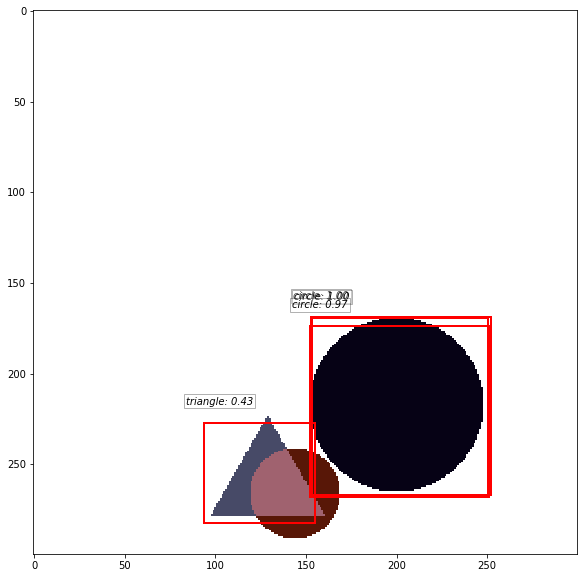

In [12]:
%matplotlib inline

image, _, _ = next(it)
model = model.cuda()
model.eval()
loc_pred, cls_pred = model(image.cuda())

i = 1
bbspred, labelpred, score = de.decode(
    loc_pred[i].float().cpu(),
    cls_pred[i].float().cpu(),
    torch.Tensor([300, 300]).float().cpu(),
    cls_thresh=0.2, nms_thresh=0.01
)
imagepil = ToPILImage()(image[1])

d = {0: 'circle', 1: 'triangle',  2: 'rectanglee'}
B = bbspred.detach().cpu().numpy()
L = labelpred.detach().cpu().numpy()
S = score.detach().cpu().numpy()

L = [d[i] for i in L]
f = vis_image(imagepil, bbspred.detach().numpy(), label_names=L, scores=S)